## Load Data

In [ ]:
# importing required modules
from zipfile import ZipFile
  
# specifying the zip file name
file_name = "/content/face-expression-recognition-dataset.zip"
  
# opening the zip file in READ mode
with ZipFile(file_name, 'r') as zip:
    # printing all the contents of the zip file
    zip.printdir()
  
    # extracting all the files
    print('Extracting all the files now...')
    zip.extractall()
    print('Done!')

In [65]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt

In [68]:
from tensorflow.keras.utils import load_img, img_to_array
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Input, Dropout, GlobalAveragePooling2D
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import BatchNormalization
from keras.layers import Activation
from keras.layers import MaxPooling2D
from keras.models import Model, Sequential
#from tensorflow.python.keras.optimizer_v2.adam import Adam
#from keras.optimizers import adam_v2
from tensorflow.keras.optimizers import RMSprop
#from keras.optimizers import rmsprop
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam
#, SGD,RMSpro

In [99]:
picture_size = 64
folder_path = "/content/images/"

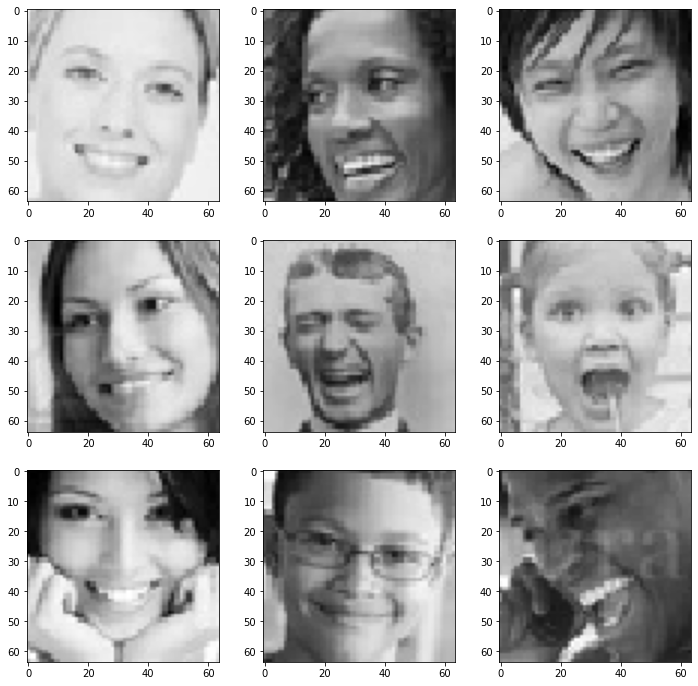

In [100]:
expression = 'happy'

plt.figure(figsize= (12,12))
for i in range(1, 10, 1):
    plt.subplot(3,3,i)
    img = load_img(folder_path+"train/"+expression+"/"+
                  os.listdir(folder_path + "train/" + expression)[i], target_size=(picture_size, picture_size))
    plt.imshow(img)   
plt.show()

## Image augmentation using keras ImageDataGenerator

In [138]:
batch_size  = 128

datagen_train  = ImageDataGenerator()
datagen_val = ImageDataGenerator()

train_set = datagen_train.flow_from_directory(folder_path+"train",
                                              target_size = (picture_size,picture_size),
                                              color_mode = "grayscale",
                                              batch_size=batch_size,
                                              class_mode='categorical',
                                              shuffle=True)


test_set = datagen_val.flow_from_directory(folder_path+"validation",
                                              target_size = (picture_size,picture_size),
                                              color_mode = "grayscale",
                                              batch_size=batch_size,
                                              class_mode='categorical',
                                              shuffle=False)

Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.


## Define model

In [139]:
no_of_classes = 7

model = Sequential()

#1st CNN layer
model.add(Conv2D(64,(3,3),padding = 'same',input_shape = (picture_size,picture_size,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))

#2nd CNN layer
model.add(Conv2D(128,(5,5),padding = 'same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout (0.25))

#3rd CNN layer
model.add(Conv2D(512,(3,3),padding = 'same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout (0.25))

#4th CNN layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())

#Fully connected 1st layer
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))


# Fully connected layer 2nd layer
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(no_of_classes, activation='softmax'))

In [141]:
model.summary()


Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_36 (Conv2D)          (None, 64, 64, 64)        640       
                                                                 
 batch_normalization_54 (Bat  (None, 64, 64, 64)       256       
 chNormalization)                                                
                                                                 
 activation_54 (Activation)  (None, 64, 64, 64)        0         
                                                                 
 max_pooling2d_36 (MaxPoolin  (None, 32, 32, 64)       0         
 g2D)                                                            
                                                                 
 dropout_54 (Dropout)        (None, 32, 32, 64)        0         
                                                                 
 conv2d_37 (Conv2D)          (None, 32, 32, 128)      

In [144]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import tensorflow as tf

checkpoint = ModelCheckpoint("./model_weights.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

reduce_learningrate = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=3,
                              verbose=1,
                              min_delta=0.0001)

early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=5, verbose=1, mode='auto')

callbacks_list = [checkpoint,reduce_learningrate, early]

epochs = 100

model.compile(loss='categorical_crossentropy',
              optimizer = Adam(lr=0.001),
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

## Train model

In [ ]:
history = model.fit(train_set,
                    steps_per_epoch=train_set.n//train_set.batch_size,
                    epochs=epochs,
                    validation_data = test_set,
                    validation_steps = test_set.n//test_set.batch_size,
                    callbacks=callbacks_list
                    )

Epoch 1/100
225/225 [==============================] - ETA: 0s - loss: 1.7420 - accuracy: 0.3358 - precision: 0.5071 - recall: 0.1418
Epoch 1: val_accuracy improved from -inf to 0.41293, saving model to ./model_weights.h5
225/225 [==============================] - 31s 90ms/step - loss: 1.7420 - accuracy: 0.3358 - precision: 0.5071 - recall: 0.1418 - val_loss: 1.5676 - val_accuracy: 0.4129 - val_precision: 0.5814 - val_recall: 0.2881 - lr: 0.0010
Epoch 2/100
225/225 [==============================] - ETA: 0s - loss: 1.4073 - accuracy: 0.4584 - precision: 0.6749 - recall: 0.2597
Epoch 2: val_accuracy improved from 0.41293 to 0.46293, saving model to ./model_weights.h5
225/225 [==============================] - 20s 88ms/step - loss: 1.4073 - accuracy: 0.4584 - precision: 0.6749 - recall: 0.2597 - val_loss: 1.5090 - val_accuracy: 0.4629 - val_precision: 0.5566 - val_recall: 0.3661 - lr: 0.0010
Epoch 3/100
225/225 [==============================] - ETA: 0s - loss: 1.2546 - accuracy: 0.5188 

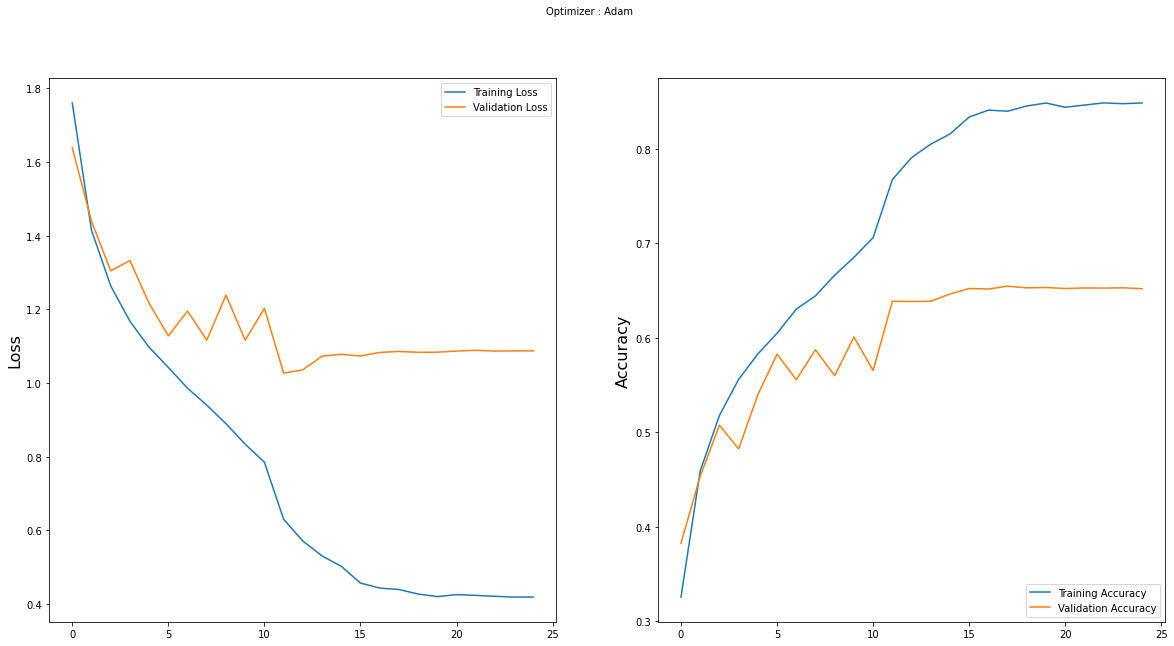

In [146]:
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

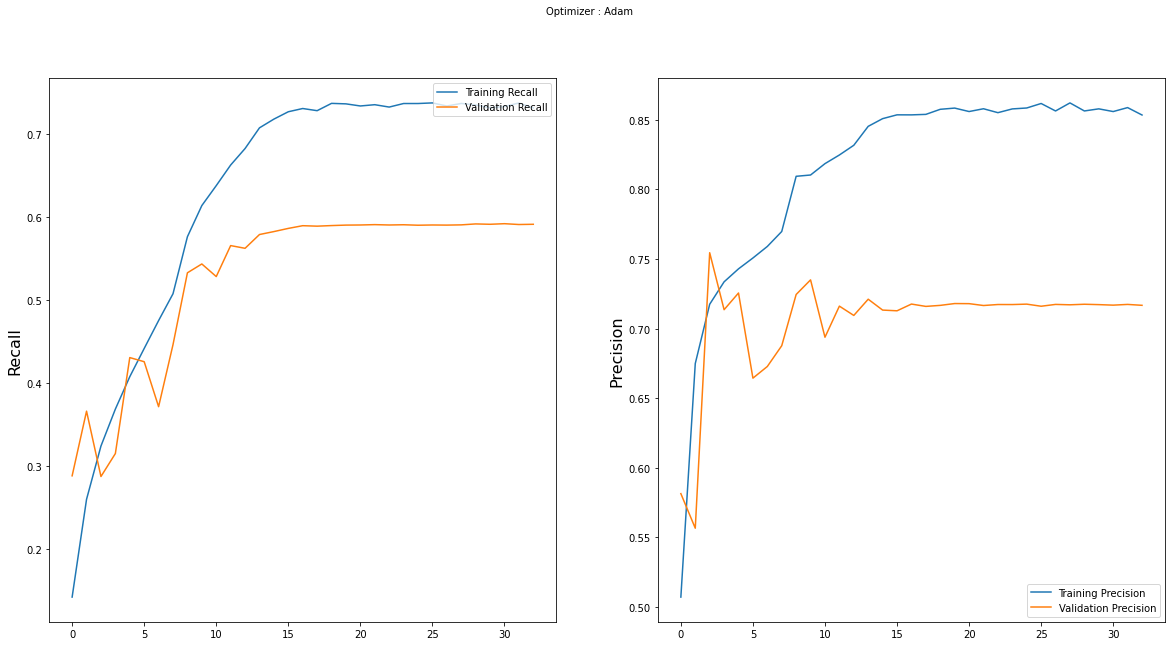

In [ ]:
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Recall', fontsize=16)
plt.plot(history.history['recall'], label='Training Recall')
plt.plot(history.history['val_recall'], label='Validation Recall')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Precision', fontsize=16)
plt.plot(history.history['precision'], label='Training Precision')
plt.plot(history.history['val_precision'], label='Validation Precision')
plt.legend(loc='lower right')
plt.show()

In [147]:
# serialize model to JSON
model_json = model.to_json()
with open("/content/model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
# model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


In [150]:
from tensorflow.keras.models import model_from_json

model_json_file = '/content/model.json'
model_weights_file = '/content/model_weights.h5'
with open(model_json_file, "r") as json_file:
    loaded_model_json = json_file.read()
    loaded_model = model_from_json(loaded_model_json)
    loaded_model.load_weights(model_weights_file)


In [151]:
images_predict = {"angry": "8969.jpg", "disgust": "14954.jpg", "fear": "10409.jpg", "happy": "10019.jpg", "neutral": "10033.jpg", "sad": "10004.jpg", "surprise": "1033.jpg"}

In [152]:
import cv2

## Test predictions

In [153]:
images_path = "/content/images/images/validation/"

label_map = (train_set.class_indices)
print(label_map)

for key in images_predict:
  image_sample = cv2.imread(images_path + key + "/" + images_predict[key])
  gray = cv2.cvtColor(image_sample, cv2.COLOR_BGR2GRAY)
  roi = cv2.resize(gray, (picture_size,picture_size))
  y_probs = loaded_model.predict(roi[np.newaxis, :, :, np.newaxis])
  val  = np.argmax(y_probs, axis=-1)[0]
  for k, v in label_map.items():
    if val == v:
        print("Predicted: {}, Should be: {}".format(k,key))


{'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}
1/1 [==============================] - 0s 136ms/step
Predicted: fear, Should be: angry
1/1 [==============================] - 0s 17ms/step
Predicted: neutral, Should be: disgust
1/1 [==============================] - 0s 20ms/step
Predicted: happy, Should be: fear
1/1 [==============================] - 0s 15ms/step
Predicted: happy, Should be: happy
1/1 [==============================] - 0s 14ms/step
Predicted: neutral, Should be: neutral
1/1 [==============================] - 0s 14ms/step
Predicted: angry, Should be: sad
1/1 [==============================] - 0s 19ms/step
Predicted: surprise, Should be: surprise


[source](https://www.kaggle.com/code/prashant808/emotion-detection-using-cnn/notebook)